In [286]:
import numpy as np
from funcy import flatten
import copy

import jointpmf as jp
ds = jp.ds  # shorthand

# import networkx as netx  # IMPORTANT: if you import networkx then don't use `nx`! ALready used as variable name below.

import itertools

import importlib
import matplotlib.pyplot as plt

import pandas as pd
from scipy.optimize import minimize

from funcy import flatten
import time
import warnings

from typing import Iterable, Sequence, Any

In [287]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [288]:
importlib.reload(ds)

<module 'jointpmf.direct_srv' from 'C:\\Users\\rquax1\\Repositories\\jointpmf_package\\src\\jointpmf\\direct_srv.py'>

In [289]:
ps = [np.random.uniform(0, 1, 3) for _ in range(2)]  # generate random marginal input distributions, for testing
# ps = np.ones((2, 3))  # generate uniform marginal input distributions

# ps instances that lead to VIOLATIONS in the direct SRV algorithm:
# ps = [[0.43, 0.35, 0.22], [0.52, 0.44, 0.04]]
# ps = [[0.45, 0.29, 0.26], [0.36, 0.43, 0.21]]

ps = [p / np.sum(p) for p in ps]  # just in case

ps

[array([0.44, 0.32, 0.24]), array([0.40, 0.29, 0.31])]

In [290]:
kxs = tuple(len(p) for p in ps)  # number of values for each input variable
ks = max(kxs)  # number of states for the SRV to be constructed
srv_ps_shape = kxs + (ks,)  # for convenience, used in multiple places below
# srv_ps = np.random.random(srv_ps_shape)
# srv_ps /= srv_ps.sum(axis=-1, keepdims=True)  # normalize each Pr(S | X=x)

# Find a direct SRV

In [291]:
# on_violation = 'raise'
# on_violation = 'warning'
on_violation = 'continue'

In [292]:
def print_info_stats(ps, direct_srv, prefix=''):
      """Prints entropy and mutual information statistics for the given input distribution and SRV.
      """
      print(f'{prefix}I(S:X) = {ds.mutual_information_srv_all_inputs(direct_srv, ps):.2f}. ' 
            + f'H(X_i)={[f"{ds.entropy_input(xix, ps):.2f}" for xix in range(len(ps))]}'
            + f'. I(S:X_i)={[f"{ds.mutual_information_srv_given_single_input(xix, ps, direct_srv):.5f}" for xix in range(len(ps))]}')

In [293]:
ps  # reminder

[array([0.44, 0.32, 0.24]), array([0.40, 0.29, 0.31])]

In [294]:
direct_srv_joint, totviol_joint = ds.compute_direct_srv_assuming_independence(ps, ks, method='joint', return_also_violation=True, 
                                                                              on_violation=on_violation, verbose=0)

print(f'Total violation (0=perfect SRV): {totviol_joint}')
direct_srv_joint

Total violation (0=perfect SRV): 0.014573971359897242


array([[[0.13, 0.67, 0.20],
        [0.08, 0.00, 0.92],
        [0.65, 0.16, 0.18]],

       [[0.71, 0.07, 0.22],
        [0.00, 1.00, 0.00],
        [0.00, 0.00, 1.00]],

       [[0.00, 0.00, 1.00],
        [1.00, 0.00, 0.00],
        [0.00, 1.00, 0.00]]])

In [295]:
print_info_stats(ps, direct_srv_joint)
p_S_joint_vanilla = ds.marginal_srv_ps(direct_srv_joint, ps)
p_S_joint_vanilla

I(S:X) = 0.99. H(X_i)=['1.54', '1.57']. I(S:X_i)=['0.00004', '0.00008']


array([0.28, 0.32, 0.40])

## Turn on backtracking, see if that helps (lower/zero violation)

In [299]:
direct_srv_joint_backtracked, totviol_joint_backtracked = ds.compute_direct_srv_assuming_independence(ps, ks, method='joint', return_also_violation=True, 
                                                                                                      on_violation=on_violation, backtrack=ks-1, verbose=0)

print(f'Total violation (0=perfect SRV): {totviol_joint_backtracked}')
direct_srv_joint_backtracked

Total violation (0=perfect SRV): 3.5267116576607314


array([[[0.13, 0.22, 0.65],
        [0.08, 0.00, 0.92],
        [0.28, 0.72, 0.00]],

       [[0.71, 0.07, 0.22],
        [0.00, 1.00, 0.00],
        [0.00, 0.00, 1.00]],

       [[0.00, 0.78, 0.22],
        [1.00, 0.00, 0.00],
        [0.00, 0.00, 1.00]]])

In [300]:
print_info_stats(ps, direct_srv_joint_backtracked)
p_S_joint_backtracked = ds.marginal_srv_ps(direct_srv_joint_backtracked, ps)
p_S_joint_backtracked

I(S:X) = 0.93. H(X_i)=['1.54', '1.57']. I(S:X_i)=['0.01785', '0.02752']


array([0.23, 0.31, 0.45])

In [301]:
# compute the sum of the individual MI of direct_srv_joint_backtracked
sum_indiv_mis_backtracked = sum(ds.mutual_information_srv_given_single_input(xix, ps, direct_srv_joint_backtracked) for xix in range(len(ps)))
sum_indiv_mis_vanilla = sum(ds.mutual_information_srv_given_single_input(xix, ps, direct_srv_joint) for xix in range(len(ps)))

print(f'Sum of individual MI (backtracked): {sum_indiv_mis_backtracked:.8f}')
print(f'Sum of individual MI (vanilla): {sum_indiv_mis_vanilla:.8f}')

Sum of individual MI (backtracked): 0.04536713
Sum of individual MI (vanilla): 0.00011957


In [ ]:
# TODO: ideas for better backtracking:
#  * make the while loop in compute_direct_srv_assuming_independence actually popping from a queue, then try to invert the order 
#    in case of violations (so set the current as well as previous SRV distribution to zero, and add the corresponding xvals_ix's to the queue
#    in reverse order)
# TODO: another idea to resolve violations:
#  * identify which single-input-state conditional distribution is creating the violation (e.g., p(S|Xi=j)), and then try to fix that one
#    by performing a simple local gradient descent on the violation. (Trying to stay as close as possible to the found solution.)

## Test if using the same above resulting `p(S)` as a target leads to the same result

In [117]:
min_totviol_over_orderings = np.inf

for method_ordering in ('unbounded', 'closest_to_1', 'closest_to_1_above_1'):
    direct_srv_joint_same, totviol_joint_same = ds.compute_direct_srv_assuming_independence(ps, ks, method='joint', 
                                                                                            p_S=p_S_joint_vanilla,
                                                                                            return_also_violation=True,
                                                                                            method_ordering=method_ordering, 
                                                                                            on_violation='continue', verbose=1)

    print(f'--- {method_ordering=} ---')
    print(f'Total violation (0=perfect SRV): {totviol_joint_same}')
    print(direct_srv_joint_same)

    min_totviol_over_orderings = min(min_totviol_over_orderings, totviol_joint_same)

if not min_totviol_over_orderings <= totviol_joint + 1e-7:
    warnings.warn(f'We haven\'t found the perfect ordering yet, because giving the same target p(S) as was already found above yields a higher violation, which is not ideal.')

--- method_ordering='unbounded' ---
Total violation (0=perfect SRV): 0.11857909532328126
[[[0.00 0.52 0.48]
  [0.51 0.18 0.31]
  [0.51 0.00 0.49]]

 [[0.36 0.00 0.64]
  [0.00 0.70 0.30]
  [0.00 1.00 0.00]]

 [[0.42 0.58 0.00]
  [0.00 0.11 0.89]
  [0.00 0.00 1.00]]]
--- method_ordering='closest_to_1' ---
Total violation (0=perfect SRV): 0.02371581906465603
[[[0.00 0.48 0.52]
  [0.51 0.23 0.26]
  [0.00 0.00 1.00]]

 [[0.41 0.00 0.59]
  [0.00 0.70 0.30]
  [0.00 1.00 0.00]]

 [[0.35 0.65 0.00]
  [0.00 0.02 0.98]
  [1.00 0.00 0.00]]]
--- method_ordering='closest_to_1_above_1' ---
Total violation (0=perfect SRV): 0.02371581906465603
[[[0.00 0.48 0.52]
  [0.51 0.23 0.26]
  [0.00 0.00 1.00]]

 [[0.41 0.00 0.59]
  [0.00 0.70 0.30]
  [0.00 1.00 0.00]]

 [[0.35 0.65 0.00]
  [0.00 0.02 0.98]
  [1.00 0.00 0.00]]]


In [118]:
print_info_stats(ps, direct_srv_joint_same)
p_S_joint_same_target = ds.marginal_srv_ps(direct_srv_joint_same, ps)
p_S_joint_same_target

I(S:X) = 0.60. H(X_i)=['1.53', '1.20']. I(S:X_i)=['0.00012', '0.00000']


array([0.22, 0.35, 0.43])

## Use directly one of the marginal input distributions as target `p(S)`

In [119]:
# what about of either of the marginal input distributions would be used as target p(S)?
direct_srv_joint_pS0, totviol_joint_pS0 = ds.compute_direct_srv_assuming_independence(ps, ks, method='joint', p_S=ps[0], return_also_violation=True, 
                                                                                      on_violation=on_violation, verbose=1)
direct_srv_joint_pS1, totviol_joint_pS1 = ds.compute_direct_srv_assuming_independence(ps, ks, method='joint', p_S=ps[1], return_also_violation=True, 
                                                                                      on_violation=on_violation, verbose=1)

print(f'Total violation (0=perfect SRV): {totviol_joint_pS0}')
print(f'Total violation (0=perfect SRV): {totviol_joint_pS1}')

Total violation (0=perfect SRV): 0.11857909532328148
Total violation (0=perfect SRV): 0.021559835513323522


In [120]:
# what about of either of the SORTED marginal input distributions would be used as target p(S)?
direct_srv_joint_pS0, totviol_joint_pS0 = ds.compute_direct_srv_assuming_independence(ps, ks, method='joint', p_S=sorted(ps[0]), return_also_violation=True, 
                                                                                      on_violation=on_violation, verbose=1)
direct_srv_joint_pS1, totviol_joint_pS1 = ds.compute_direct_srv_assuming_independence(ps, ks, method='joint', p_S=sorted(ps[1]), return_also_violation=True, 
                                                                                      on_violation=on_violation, verbose=1)

print(f'Total violation (0=perfect SRV): {totviol_joint_pS0}')
print(f'Total violation (0=perfect SRV): {totviol_joint_pS1}')

print_info_stats(ps, direct_srv_joint_pS0)
print(ds.marginal_srv_ps(direct_srv_joint_pS0, ps))
print_info_stats(ps, direct_srv_joint_pS1)
print(ds.marginal_srv_ps(direct_srv_joint_pS1, ps))

Total violation (0=perfect SRV): 0.11857909532328148
Total violation (0=perfect SRV): 0.021559835513323522
I(S:X) = 0.55. H(X_i)=['1.53', '1.20']. I(S:X_i)=['0.00313', '0.00000']
[0.22 0.35 0.43]
I(S:X) = 0.50. H(X_i)=['1.53', '1.20']. I(S:X_i)=['0.00015', '0.00010']
[0.04 0.44 0.52]


## Chase

If the default algorithm does not lead to a solution with zero violation, then use the most violating `p(S|X=j)` (for some j) as the new target `p(S)` and keep doing this until (near) zero violation is found (if ever).

In [121]:
## try to CHASE

direct_srv_joint_chased, totviol_joint_chased = ds.compute_direct_srv_assuming_independence(ps, ks, method='joint', return_also_violation=True, 
                                                                              on_violation=on_violation, verbose=1, chase_violations=100)

print(f'Total violation (0=perfect SRV): {totviol_joint_chased}')
direct_srv_joint_chased

debug: [CHASE=1] recursed on a violating p(S|X_i=j)=[0.00 0.45 0.55]  (target p(S)=[0.00 0.45 0.55]).  total_viol_chase=7.251726370505196e-07 --> total_violation=8.18143488290346e-07
debug: [CHASE=2] recursed on a violating p(S|X_i=j)=[0.00 0.45 0.55]  (target p(S)=[0.00 0.45 0.55]).  total_viol_chase=7.251726370505196e-07 --> total_violation=9.230336794896488e-07
debug: [CHASE=3] recursed on a violating p(S|X_i=j)=[0.00 0.45 0.55]  (target p(S)=[0.00 0.45 0.55]).  total_viol_chase=7.251726370505196e-07 --> total_violation=1.0413713305013061e-06
debug: [CHASE=4] recursed on a violating p(S|X_i=j)=[0.00 0.45 0.55]  (target p(S)=[0.00 0.45 0.55]).  total_viol_chase=7.251726370505196e-07 --> total_violation=1.174880475240947e-06
debug: [CHASE=5] recursed on a violating p(S|X_i=j)=[0.00 0.45 0.55]  (target p(S)=[0.00 0.45 0.55]).  total_viol_chase=7.251726370505196e-07 --> total_violation=1.3255061770411913e-06
debug: [CHASE=6] recursed on a violating p(S|X_i=j)=[0.00 0.45 0.55]  (target p

array([[[0.00, 0.01, 0.99],
        [0.00, 1.00, 0.00],
        [0.00, 0.24, 0.76]],

       [[0.00, 0.74, 0.26],
        [0.00, 0.06, 0.94],
        [0.00, 1.00, 0.00]],

       [[0.00, 0.87, 0.13],
        [0.00, 0.00, 1.00],
        [0.00, 0.00, 1.00]]])

In [122]:
print_info_stats(ps, direct_srv_joint_chased)
ds.marginal_srv_ps(direct_srv_joint_chased, ps)

I(S:X) = 0.70. H(X_i)=['1.53', '1.20']. I(S:X_i)=['0.00000', '0.00000']


array([0.00, 0.45, 0.55])

In [123]:
# TODO: debug the chase behavior, in compare_srv_methods.ipynb it actually appears to be worse than the vanilla joint method,
# which is not what we would expect.

## Try a whole 'line' of target `p(S)`s

The line defined by the two marginal distributions of the two inputs.

In [124]:
# test a range of alpha values and plot the violation and total MI as function of alpha

dict_alpha_to_viol = dict()
dict_alpha_to_mi = dict()
dict_alpha_to_indiv_mis = dict()

for alpha in np.linspace(-3.0, 4.0, 80):
    p_S_a_prior = np.add(np.multiply(ps[0], 1.0 - alpha), np.multiply(ps[1], alpha))

    if np.all(p_S_a_prior < 1.0) and np.all(p_S_a_prior > 0.0):
        direct_srv, totviol_engineered = ds.compute_direct_srv_assuming_independence(ps, ks, method='joint', p_S=p_S_a_prior, 
                                                                                                return_also_violation=True, 
                                                                                                on_violation=on_violation, 
                                                                                                chase_violations=0, verbose=0)

        dict_alpha_to_viol[alpha] = totviol_engineered
        dict_alpha_to_mi[alpha] = ds.mutual_information_srv_all_inputs(direct_srv, ps)
        dict_alpha_to_indiv_mis[alpha] = [ds.mutual_information_srv_given_single_input(xix, ps, direct_srv) for xix in range(len(ps))]

# make a line plot of violation and mi versus alpha

# Extract the values from the dictionaries
alphas = list(dict_alpha_to_viol.keys())
violations = list(dict_alpha_to_viol.values())
mi_values = list(dict_alpha_to_mi.values())

# Plot the violation
plt.plot(alphas, violations, label='Violation')

# Plot the mutual information
plt.plot(alphas, mi_values, label='Mutual Information')

# Set the labels and title
plt.xlabel('Alpha')
plt.ylabel('Value')
plt.title('Violation and Mutual Information vs Alpha')

plt.ylim([0, plt.ylim()[-1]])

# Add a legend
plt.legend()

# Show the plot
plt.show()


## Now explore the whole `k-1`-dimensional space for `p(S)`

In [125]:
df_pS = pd.DataFrame(columns=[f'ps_unit_{i}' for i in range(ks-1)] + ['p_S', 'violation', 'syninfo_lb', 'total_MI'])

npoints_per_dim = 34

for ps_unit in itertools.product(np.linspace(0.0, 1.0, npoints_per_dim), repeat=ks-1):
    p_S_target = ds.single_unit_cube_coord_to_ps(ps_unit)
    
    direct_srv, totviol_engineered = ds.compute_direct_srv_assuming_independence(ps, ks, method='joint', p_S=p_S_target,
                                                                                 return_also_violation=True, 
                                                                                 on_violation='continue', 
                                                                                 chase_violations=0, verbose=0)
    
    total_MI = ds.mutual_information_srv_all_inputs(direct_srv, ps)
    indiv_mis = [ds.mutual_information_srv_given_single_input(xix, ps, direct_srv) for xix in range(len(ps))]
    syninfo_lb = total_MI - sum(indiv_mis)

    row = list(ps_unit) + [p_S_target, totviol_engineered, syninfo_lb, total_MI]
    assert len(row) == len(df_pS.columns), f'error: {len(row)} != {len(df_pS.columns)}'

    df_pS.loc[len(df_pS)] = row

In [126]:
df_pS.head()

ps_unit_0  ps_unit_1                                              p_S  \
0        0.0   0.000000                                  [0.0, 0.0, 1.0]   
1        0.0   0.030303  [0.0, 0.030303030303030304, 0.9696969696969697]   
2        0.0   0.060606   [0.0, 0.06060606060606061, 0.9393939393939394]   
3        0.0   0.090909   [0.0, 0.09090909090909091, 0.9090909090909091]   
4        0.0   0.121212   [0.0, 0.12121212121212122, 0.8787878787878788]   

   violation  syninfo_lb  total_MI  
0   0.000000   -0.000000 -0.000000  
1   0.016333    0.029218  0.029406  
2   0.032666    0.059749  0.060135  
3   0.049000    0.091723  0.092321  
4   0.065333    0.125294  0.126117

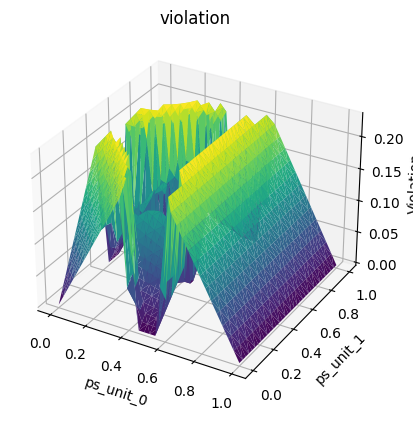

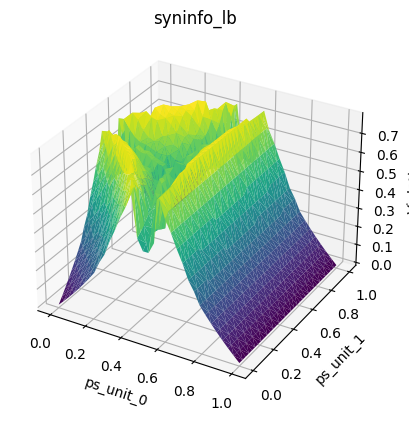

In [127]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract x, y, and z values from the DataFrame
x = df_pS['ps_unit_0']
y = df_pS['ps_unit_1']

for z_measure in ('violation', 'syninfo_lb'):
    z = df_pS[z_measure]

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_trisurf(x, y, z, cmap='viridis')

    # Set the labels and title 
    ax.set_xlabel('ps_unit_0')
    ax.set_ylabel('ps_unit_1')
    ax.set_zlabel('Violation')

    ax.set_title(f'{z_measure}')

    plt.show()

## Optimize over the target `p(S)`

In [128]:
import numpy as np
from scipy.optimize import minimize

# Define the objective function to maximize
def objective_function(ps_unit):
    p_S_target = ds.single_unit_cube_coord_to_ps(ps_unit)
    
    direct_srv, totviol = ds.compute_direct_srv_assuming_independence(ps, ks, method='joint', p_S=p_S_target,
                                                                                 return_also_violation=True, 
                                                                                 on_violation='continue', 
                                                                                 chase_violations=0, verbose=0)
    
    total_MI = ds.mutual_information_srv_all_inputs(direct_srv, ps)
    # indiv_mis = [ds.mutual_information_srv_given_single_input(xix, ps, direct_srv) for xix in range(len(ps))]
    # syninfo_lb = total_MI - sum(indiv_mis)

    # NOTE: under normal operation, the `totviol` is in units of probability mass, so for sure >= 0.0,
    # and usually lower than 1.0 (but theoretically could be >1 for very bad solutions). I have seen mostly 
    # either zero or values like 0.1 or perhaps 0.2. Since `total_MI` is in units of bits, it makes little
    # sense to subtract the two quantities. So, I multiply them. Also, it saves computations compared
    # to computing `syninfo_lb` as above.
    
    # Return the negative value (higher is better; the more negative, the worse)
    return -total_MI * (1.0 - totviol)

# Initial guess for ps_unit
initial_ps_unit = np.array([0.5, 0.5])

# Define the bounds for ps_unit
bounds = [(0.0, 1.0), (0.0, 1.0)]

# Perform the gradient ascent optimization
result = minimize(objective_function, initial_ps_unit, method='L-BFGS-B', bounds=bounds)

# Get the optimized ps_unit values
optimized_ps_unit = result.x

p_S_optimized = ds.single_unit_cube_coord_to_ps(optimized_ps_unit)

print("Optimized target p(S):", p_S_optimized)

Optimized target p(S): [0.54 0.15 0.32]


## Try the 'marginal' method

In [22]:
# direct_srv_marginal, totviol_marginal = ds.compute_direct_srv_assuming_independence(ps, ks, method='marginal', return_also_violation=True, on_violation=on_violation, verbose=0)

In [105]:
## now CHASE

# TODO: figure out why in this case there is no (or not always?) chase happening, even if there is clearly a violation?
direct_srv_marginal_chased, totviol_marginal_chased = ds.compute_direct_srv_assuming_independence(ps, ks, method='marginal', return_also_violation=True, on_violation='continue', 
                                                                                                  verbose=2, chase_violations=0)

totviol_marginal_chased

hack: the input variable with minimum probability for one of its states is variable 1, which is not 0, so I reorder the input probabilities because there is a bug somewhere.
debug: it is now determined: p_S=array([0.22, 0.35, 0.43])


0.02371581906465625

In [106]:
direct_srv_marginals = dict()
totviol_marginals = dict()
for xix in range(len(ps)):
    print(f'debug: first_xix={xix}')
    direct_srv_marginals[xix], totviol_marginals[xix] = ds.compute_direct_srv_assuming_independence(ps, ks, method='marginal', first_xix=xix, 
                                                                                                    return_also_violation=True, on_violation=on_violation, verbose=1,
                                                                                                    chase_violations=0)

print(f'Total violations: {totviol_marginals}')

direct_srv_marginals

debug: first_xix=0
debug: first_xix=1
Total violations: {0: 0.03252561392096287, 1: 0.02371581906465625}


{0: array([[[0.00, 0.33, 0.67],
         [0.09, 0.51, 0.40],
         [0.00, 1.00, 0.00]],
 
        [[0.08, 0.85, 0.08],
         [0.00, 0.00, 1.00],
         [0.00, 0.00, 1.00]],
 
        [[0.00, 0.00, 1.00],
         [0.00, 1.00, 0.00],
         [1.00, 0.00, 0.00]]]),
 1: array([[[0.00, 0.48, 0.52],
         [0.51, 0.23, 0.26],
         [0.00, 0.00, 1.00]],
 
        [[0.41, 0.00, 0.59],
         [0.00, 0.70, 0.30],
         [0.00, 1.00, 0.00]],
 
        [[0.35, 0.65, 0.00],
         [0.00, 0.02, 0.98],
         [1.00, 0.00, 0.00]]])}

In [25]:
# these are the amounts of violations of the SRV constraints for each of the algorithms
# (of `totviol_marginals` there will often be at most one entry zero, the rest non-zero,
# because apparently it doesn't pay to go row-wise or column-wise on the not-smallest-marginal-probability)
totviol_joint, totviol_marginals

(0.0, {0: 0.0, 1: 0.017653835492659642})

In [26]:
print_info_stats(ps, direct_srv_joint)
print_info_stats(ps, direct_srv_joint_chased)
print_info_stats(ps, direct_srv_marginals[0], '-- ')
print_info_stats(ps, direct_srv_marginals[1], '-- ')

I(S:X) = 0.62. H(X_i)=['1.24', '1.45']. I(S:X_i)=['0.00000', '-0.00000']
I(S:X) = 0.62. H(X_i)=['1.24', '1.45']. I(S:X_i)=['0.00000', '-0.00000']
-- I(S:X) = 0.62. H(X_i)=['1.24', '1.45']. I(S:X_i)=['0.00000', '-0.00000']
-- I(S:X) = 0.34. H(X_i)=['1.24', '1.45']. I(S:X_i)=['0.00310', '-0.00000']


# Optimize for an SRV using SLSQP

In [36]:
scipy_tol = 1e-4

In [37]:
random_srv_ps = np.random.random(srv_ps_shape)
random_srv_ps /= random_srv_ps.sum(axis=-1, keepdims=True)  # normalize each Pr(S | X=x)

In [38]:
time_opt_random_srv = time.time()
opt_srv = ds.optimize_srv_using_scipy(random_srv_ps, ps, verbose=1, tol=scipy_tol)
time_opt_random_srv = time.time() - time_opt_random_srv

print(f'Time taken: {time_opt_random_srv}')

opt_srv

optres.success=True
optres.message='Optimization terminated successfully'
Optimal SRV found: srv_ps_opt=array([[[0.01, 0.64, 0.35],
        [0.80, 0.20, 0.00],
        [0.50, 0.00, 0.50]],

       [[1.00, 0.00, 0.00],
        [0.00, 0.20, 0.80],
        [0.00, 0.91, 0.09]],

       [[0.30, 0.00, 0.70],
        [0.00, 1.00, 0.00],
        [1.00, 0.00, 0.00]]])
Constraint SRV (should be zero): constraint_srv(srv_ps_opt, ps)=9.152957385265115e-05
Objective function (should be as high as possible): mutual_information_srv_all_inputs(srv_ps_opt, ps)=0.9367965612050662
Upper bound (not necessarily tight) of the objective function: 1.4406454496153462
Time taken: 2.2379720211029053


array([[[0.01, 0.64, 0.35],
        [0.80, 0.20, 0.00],
        [0.50, 0.00, 0.50]],

       [[1.00, 0.00, 0.00],
        [0.00, 0.20, 0.80],
        [0.00, 0.91, 0.09]],

       [[0.30, 0.00, 0.70],
        [0.00, 1.00, 0.00],
        [1.00, 0.00, 0.00]]])

In [39]:
jp.ds.conditional_srv_given_single_input(0, 1, ps, opt_srv)

array([0.40, 0.32, 0.28])

In [40]:
# ...which is not necessarily close to one of the input marginal distributions:
ps

[[0.5, 0.35, 0.15], [0.4, 0.32, 0.28]]

In [41]:
print(f'I(S:X) = {ds.mutual_information_srv_all_inputs(opt_srv, ps):.2f}. ' 
      + f'H(X_i)={[f"{ds.entropy_input(xix, ps):.2f}" for xix in range(len(ps))]}'
      + f'. I(S:X_i)={[f"{ds.mutual_information_srv_given_single_input(xix, ps, opt_srv):.4f}" for xix in range(len(ps))]}')

I(S:X) = 0.94. H(X_i)=['1.44', '1.57']. I(S:X_i)=['0.0000', '0.0000']


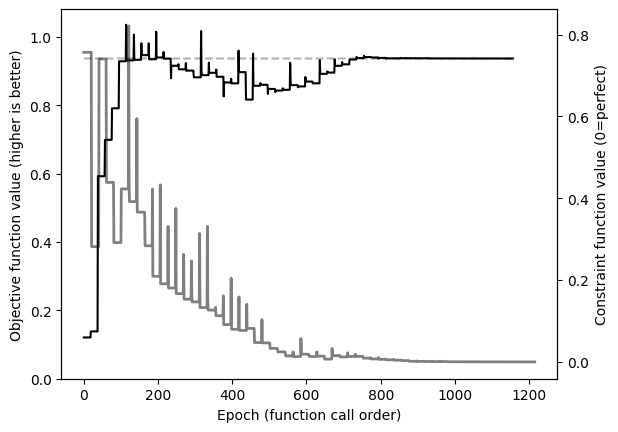

In [42]:
ds.plot_most_recent_objective_function_curve_from_log(opt_srv, ps)

## Now starting from a direct SRV

In [43]:
time_opt_joint_srv = time.time()
opt_direct_srv = ds.optimize_srv_using_scipy(direct_srv_joint, ps, tol=scipy_tol, verbose=1)
time_opt_joint_srv = time.time() - time_opt_joint_srv

print(f'Time taken: {time_opt_joint_srv}')

opt_direct_srv

optres.success=True
optres.message='Optimization terminated successfully'
Optimal SRV found: srv_ps_opt=array([[[0.65, 0.07, 0.28],
        [0.00, 0.37, 0.63],
        [0.33, 0.67, 0.00]],

       [[0.00, 0.84, 0.16],
        [1.00, 0.00, 0.00],
        [0.11, 0.00, 0.89]],

       [[0.18, 0.04, 0.78],
        [0.00, 1.00, 0.00],
        [1.00, 0.00, 0.00]]])
Constraint SRV (should be zero): constraint_srv(srv_ps_opt, ps)=2.636388262130793e-05
Objective function (should be as high as possible): mutual_information_srv_all_inputs(srv_ps_opt, ps)=0.8742308675525913
Upper bound (not necessarily tight) of the objective function: 1.4406454496153462
Time taken: 2.028247594833374


array([[[0.65, 0.07, 0.28],
        [0.00, 0.37, 0.63],
        [0.33, 0.67, 0.00]],

       [[0.00, 0.84, 0.16],
        [1.00, 0.00, 0.00],
        [0.11, 0.00, 0.89]],

       [[0.18, 0.04, 0.78],
        [0.00, 1.00, 0.00],
        [1.00, 0.00, 0.00]]])

In [44]:
print(f'I(S:X) = {ds.mutual_information_srv_all_inputs(opt_direct_srv, ps):.2f}. ' 
      + f'H(X_i)={[f"{ds.entropy_input(xix, ps):.2f}" for xix in range(len(ps))]}'
      + f'. I(S:X_i)={[f"{ds.mutual_information_srv_given_single_input(xix, ps, opt_direct_srv):.6f}" for xix in range(len(ps))]}')

I(S:X) = 0.87. H(X_i)=['1.44', '1.57']. I(S:X_i)=['0.000000', '0.000000']


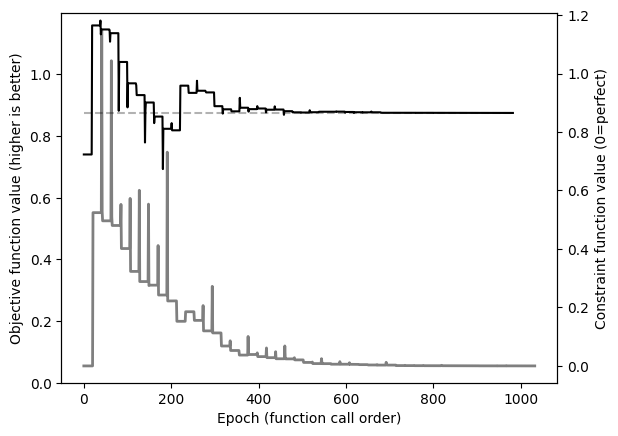

In [45]:
ds.plot_most_recent_objective_function_curve_from_log(opt_direct_srv, ps)

In [46]:
np.testing.assert_almost_equal(jp.ds.constraint_srv(opt_direct_srv, ps), 0.0, decimal=4)  # optimized SRV should satisfy the constraints

# Adding the SRV to a BN object

In [47]:
bn = jp.BayesianNetwork()

for p in ps:  # add all inputs to the BN, one at a time, and independent from each other
    # print(f'going to add {p=}')
    bn.append_independent_variable(p)

bn.append_conditional_variable(direct_srv_joint, [0, 1])

2

In [48]:
# verify here that the SRV actually 'works', so high MI with all inputs but (close to) zero MI with any individual input:
print(round(bn.mutual_information([0, 1], [2]), 2))
print([round(bn.mutual_information([xix], [2]), 4) for xix in range(len(bn) - 1)])

0.74
[0.0, 0.0]


# Append using jointpmf

In [49]:
ps

[[0.5, 0.35, 0.15], [0.4, 0.32, 0.28]]

In [50]:
bn2 = jp.BayesianNetwork()

for p in ps:  # add all inputs to the BN, one at a time, and independent from each other
    print(f'going to add {p=}')
    bn2.append_independent_variable(p)
    print(f'added {bn2.marginal_probabilities(len(bn2) - 1)} ({len(bn2)=})')
    print('put in a different way: I added: ', bn2.pdfs[len(bn2)-1].joint_probabilities.joint_probabilities)

bn2.append_direct_synergistic_variable([0, 1], 3, direct_srv_args={'return_also_violation': True, 'on_violation': 'continue'}, verbose=2)

going to add p=[0.5, 0.35, 0.15]
added [0.50 0.35 0.15] (len(bn2)=1)
put in a different way: I added:  [0.50 0.35 0.15]
going to add p=[0.4, 0.32, 0.28]
added [0.40 0.32 0.28] (len(bn2)=2)
put in a different way: I added:  [0.40 0.32 0.28]
debug: ps=[array([0.50, 0.35, 0.15], dtype=float64), array([0.40, 0.32, 0.28], dtype=float64)]
debug: numvalues=3
debug: total violation of the added SRV is 0.0


array([[[0.52, 0.19, 0.29],
        [0.00, 0.20, 0.80],
        [0.26, 0.64, 0.10]],

       [[0.06, 0.64, 0.30],
        [0.80, 0.20, 0.00],
        [0.00, 0.00, 1.00]],

       [[0.00, 0.00, 1.00],
        [0.00, 1.00, 0.00],
        [1.00, 0.00, 0.00]]])

In [51]:
# verify here that the SRV actually 'works', so high MI with all inputs but zero MI with any individual input:
print(round(bn2.mutual_information([0, 1], [2]), 2))
print([round(bn2.mutual_information([xix], [2]), 5) for xix in range(len(bn2) - 1)])

0.74
[0.0, 0.0]


In [52]:
# here I do the same but set `optimize_after=True`, which does SLSQP after finding a direct SRV. Takes longer
# but often better quality SRVs are found this way.
# also, `on_violation='continue'` ignores the error warnings

bn3 = jp.BayesianNetwork()

for p in ps:  # add all inputs to the BN, one at a time, and independent from each other
    # print(f'going to add {p=}')
    bn3.append_independent_variable(p)
    # print(f'added {bn3.marginal_probabilities(len(bn3) - 1)} ({len(bn3)=})')
    # print('put in a different way: I added: ', bn3.pdfs[len(bn3)-1].joint_probabilities.joint_probabilities)

bn3.append_direct_synergistic_variable([0, 1], 3, direct_srv_args={'return_also_violation': True, 'on_violation': 'continue'}, 
                                       optimize_after=True, verbose=0)

array([[[0.65, 0.07, 0.28],
        [0.00, 0.37, 0.63],
        [0.33, 0.67, 0.00]],

       [[0.00, 0.84, 0.16],
        [1.00, 0.00, 0.00],
        [0.11, 0.00, 0.89]],

       [[0.17, 0.04, 0.78],
        [0.00, 1.00, 0.00],
        [1.00, 0.00, 0.00]]])

In [53]:
# verify here that the SRV actually 'works', so high MI with all inputs but (close to) zero MI with any individual input:
print(round(bn3.mutual_information([0, 1], [2]), 2))
print([round(bn3.mutual_information([xix], [2]), 5) for xix in range(len(bn3) - 1)])

0.87
[0.0, 0.0]


# Compute synergistic information using a direct SRV

In [54]:
bn_syninfo = jp.BayesianNetwork()

bn_syninfo.append_independent_variable(numvalues=3)
bn_syninfo.append_independent_variable(numvalues=3)
bn_syninfo.append_dependent_variable([0, 1], numvalues=3, target_mi=0.3 * np.log2(3))

In [55]:
bn_syninfo.synergistic_information([0, 1], [2], method_srv='direct', max_num_srvs=1)

0.0

In [56]:
bn_syninfo.synergistic_information([0, 1], [2], method_srv='full')

0.0